In [1]:
#Loading all libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from xgboost import XGBClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [2]:
# Load dataset
df = pd.read_csv('lending_club_loan_dataset.csv')

# size of the dataset
df.shape

df.head()

,id,grade,annual_inc,short_emp,emp_length_num,home_ownership,dti,purpose,term,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,od_ratio,bad_loan
0,11454641,A,100000.0,1,1,RENT,26.27,credit_card,36 months,1,NaN,43.2,0.0,0.160624,0
1,9604874,A,83000.0,0,4,OWN,5.39,credit_card,36 months,0,NaN,21.5,0.0,0.810777,0
2,9684700,D,78000.0,0,11,MORTGAGE,18.45,debt_consolidation,60 months,1,NaN,46.3,0.0,0.035147,1
3,9695736,D,37536.0,0,6,MORTGAGE,12.28,medical,60 months,0,NaN,10.7,0.0,0.534887,1
4,9795013,D,65000.0,0,11,MORTGAGE,11.26,debt_consolidation,36 months,0,NaN,15.2,0.0,0.166500,0


In [3]:
df['bad_loan'].value_counts(normalize = True)

0    0.8
1    0.2
Name: bad_loan, dtype: float64

<AxesSubplot:xlabel='grade', ylabel='count'>

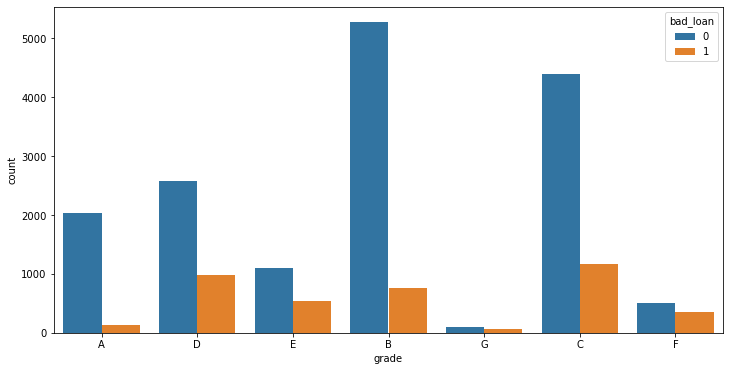

In [4]:
plt.figure(figsize = (12,6))
sns.countplot(x = 'grade', hue = 'bad_loan', data = df)

In [5]:
# Impute NULL values in home ownership by mode
df['home_ownership'] = df['home_ownership'].fillna(df['home_ownership'].mode()[0])

# Impute NULL values in dti by mean
df['dti'] = df['dti'].fillna(df['dti'].mean())

# remove last_major_derog_none columns as it contains a lot of NULL values
df.drop(['last_major_derog_none'], axis = 1, inplace = True)

# remove inconsistencies in term feature
df['term'] = df['term'].apply(lambda i : i.lower())

In [6]:
# one hot encoding
cols_to_encode = ['grade', 'home_ownership', 'purpose', 'term']
df = pd.get_dummies(data = df, columns = cols_to_encode, drop_first = True)

# Standard Scaler
standard_scaler = StandardScaler()
feature_cols = ['annual_inc', 'emp_length_num', 'dti','revol_util', 'total_rec_late_fee', 'od_ratio']
transformed_features = standard_scaler.fit_transform(df[feature_cols])

df[feature_cols] = transformed_features

# split data into train and test
feature_cols  = df.columns.tolist()
feature_cols = [i for i in feature_cols if i not in ['id', 'bad_loan']]
x_train, x_test, y_train, y_test = train_test_split(df[feature_cols], df['bad_loan'], test_size = 0.2, random_state = 1234)


In [7]:
logistic_regression_classifier = LogisticRegression(max_iter = 1000, solver = 'lbfgs', random_state = 1234, class_weight = 'balanced' )
logistic_regression_classifier.fit(x_train, y_train)

prediction_values_lr = logistic_regression_classifier.predict(x_test)
print(metrics.classification_report(y_test, prediction_values_lr, digits = 2))
print(metrics.confusion_matrix(y_test, prediction_values_lr))


              precision    recall  f1-score   support

           0       0.88      0.63      0.73      3181
           1       0.32      0.66      0.43       819

    accuracy                           0.64      4000
   macro avg       0.60      0.65      0.58      4000
weighted avg       0.76      0.64      0.67      4000

[[2003 1178]
 [ 275  544]]


In [8]:
knn_classifier = KNeighborsClassifier(n_neighbors = 100)
knn_classifier.fit(x_train, y_train)

prediction_values_knn = knn_classifier.predict(x_test)
print(metrics.classification_report(y_test, prediction_values_knn, digits = 2))
print(metrics.confusion_matrix(y_test, prediction_values_knn))

              precision    recall  f1-score   support

           0       0.80      1.00      0.89      3181
           1       0.72      0.04      0.07       819

    accuracy                           0.80      4000
   macro avg       0.76      0.52      0.48      4000
weighted avg       0.79      0.80      0.72      4000

[[3170   11]
 [ 790   29]]


In [9]:
svm_classifier = SVC(random_state = 1234, class_weight = 'balanced', probability = True, verbose = True)
svm_classifier.fit(x_train, y_train)

prediction_values_svm = svm_classifier.predict(x_test)
print(metrics.classification_report(y_test, prediction_values_svm, digits = 2))
print(metrics.confusion_matrix(y_test, prediction_values_svm))

[LibSVM]              precision    recall  f1-score   support

           0       0.88      0.64      0.74      3181
           1       0.32      0.66      0.43       819

    accuracy                           0.64      4000
   macro avg       0.60      0.65      0.59      4000
weighted avg       0.76      0.64      0.68      4000

[[2040 1141]
 [ 281  538]]


In [10]:
decision_tree_classifier = DecisionTreeClassifier(max_depth = 4, random_state = 1234)
decision_tree_classifier.fit(x_train, y_train)

prediction_values_dt = decision_tree_classifier.predict(x_test)
print(metrics.classification_report(y_test, prediction_values_dt, digits = 2))
print(metrics.confusion_matrix(y_test, prediction_values_dt))


              precision    recall  f1-score   support

           0       0.80      1.00      0.89      3181
           1       0.74      0.03      0.06       819

    accuracy                           0.80      4000
   macro avg       0.77      0.51      0.47      4000
weighted avg       0.79      0.80      0.72      4000

[[3172    9]
 [ 794   25]]


In [13]:
# Initialize XGBoost Model
xgboost_classifier = XGBClassifier(n_estimators = 5000, max_depth = 4, random_state = 1234, learning_rate = 0.3)
xgboost_classifier.fit(x_train, y_train)

# Predict label for the test data and print classification report and confusion matrix
prediction_values_xgboost = xgboost_classifier.predict(x_test)
print(metrics.classification_report(y_test, prediction_values_xgboost, digits = 2))

              precision    recall  f1-score   support

           0       0.82      0.91      0.86      3181
           1       0.37      0.20      0.26       819

    accuracy                           0.76      4000
   macro avg       0.59      0.56      0.56      4000
weighted avg       0.72      0.76      0.74      4000

